In [74]:
import numpy as np
import pandas as pd

from astropy.io import fits

from photutils.aperture import aperture_photometry, CircularAperture
from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

In [75]:
def grab_stars(file:str='b_science_reduced.fits'):
    """
    This function takes in a file and returns a dataframe with the x and y coordinates of the stars in the image.
    Uses photutils DAOStarFinder with aperture photometry to find the stars in the image.

    Parameters
    ----------
    file : str
        The name of the file to be used.
    Returns
    -------
    df : pandas dataframe
        A dataframe with the x, y coordinates and the aperture sum of the stars in the image.
    """
    
    hdu = fits.open(file)
    image = hdu[0].data

    image_1 = image -  np.nanmedian(image)

    bkg_sigma = mad_std(image_1)
    daofind = DAOStarFinder(fwhm=1.0, threshold= 2*bkg_sigma)  
    sources = daofind(image_1)
    for col in sources.colnames:  
        sources[col].info.format = '%.8g'  # for consistent table output 

    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
    apertures = CircularAperture(positions, r=5.0)  
    phot_table = aperture_photometry(image, apertures)  
    for col in phot_table.colnames:  
        phot_table[col].info.format = '%.8g'  # for consistent table output
    df = phot_table.to_pandas()

    # Sort the dataframe by aperture sum
    df = df.sort_values(by=['aperture_sum'], ascending=False)
    df = df.reset_index(drop=True)
    return df



In [76]:
x,y = 200, 510
b_science_stars = grab_stars('b_science_reduced.fits')
df = b_science_stars
df_star = df[(df['xcenter']>x) & 
   (df['xcenter']<x+20) & (df['ycenter']>y) & (
       df['ycenter']<y+20)]

L_b_star_sum = df['aperture_sum'][0].astype(float)
print(L_b_star_sum)
m_ref = 10.382 #Known star
F_ref = L_b_star_sum
df_b_cluster = grab_stars('b_cluster_reduced.fits')

F_1 = df_b_cluster['aperture_sum'].values
m_B = m_ref -2.5*np.log10(F_1/F_ref)

df_b_cluster['m_B'] = m_B

df_b_cluster['m_V'] = 100

# Remove Nan Rows
df_b_cluster = df_b_cluster[df_b_cluster['m_B'].notna()]
print(df_b_cluster)


4144.574493591831
       id     xcenter      ycenter  aperture_sum        m_B  m_V
0     629  255.997897   407.554104   3432.541664  10.586660  100
1     911  763.591437   588.333970   2828.250454  10.796905  100
2     784  763.302333   506.445231   2412.091837  10.969715  100
3     869  616.222263   552.954751   2376.478044  10.985865  100
4     188  255.998371   127.407209   2330.770174  11.006951  100
..    ...         ...          ...           ...        ...  ...
757     4  155.793306     0.601223     83.343691  14.623518  100
758    14   15.642109     6.426347     70.402809  14.806725  100
759  1559   27.192410  1000.950477     68.894391  14.830240  100
760    35    7.640192    15.809402     68.603191  14.834839  100
761     5  162.351694     0.930149     26.309061  15.875437  100

[762 rows x 6 columns]


/tmp/ipykernel_75140/2803811456.py:15: RuntimeWarning: invalid value encountered in log10
  m_B = m_ref -2.5*np.log10(F_1/F_ref)


In [77]:
x,y = 200, 510
v_science_stars = grab_stars('v_science_reduced.fits')
df = v_science_stars
df_star = df[(df['xcenter']>x) & 
   (df['xcenter']<x+20) & (df['ycenter']>y) & (
       df['ycenter']<y+20)]
print(len(df_star))
L_v_star_sum = df['aperture_sum'][0].astype(float)
print(L_v_star_sum)

m_ref = 10.382 #Known star
F_ref = L_v_star_sum
df_v_cluster = grab_stars('v_cluster_reduced.fits')

F_1 = df_v_cluster['aperture_sum'].values
m_V = m_ref -2.5*np.log10(F_1/F_ref)
df_v_cluster['m_V'] = m_V
df_v_cluster['m_B'] = 100
# Remove Nan Rows
df_v_cluster = df_v_cluster[df_v_cluster['m_V'].notna()]
print(df_v_cluster)

1
32005.821980194607
       id     xcenter      ycenter  aperture_sum        m_V  m_B
0    1133  557.134730   660.648131  12159.636604  11.432771  100
1    1139  556.924852   661.906421  11509.381705  11.492442  100
2     305  752.375358   212.123588   9597.854772  11.689637  100
3     970  764.640106   586.115479   9401.046344  11.712132  100
4     808  764.315394   506.301166   9064.855387  11.751670  100
..    ...         ...          ...           ...        ...  ...
896  1672   29.215660  1006.210137     65.678815  17.101509  100
897    26    9.092512    10.811963     64.629765  17.118991  100
898  1660   22.216813   999.175474     60.961617  17.182431  100
899  1651   18.523619   996.230242     19.746496  18.406347  100
900  1631    4.257771   980.640698      4.891021  19.921574  100

[901 rows x 6 columns]


/tmp/ipykernel_75140/377572413.py:16: RuntimeWarning: invalid value encountered in log10
  m_V = m_ref -2.5*np.log10(F_1/F_ref)


In [78]:
# Cross match the stars
df_b_cluster = df_b_cluster.reset_index(drop=True)
df_v_cluster = df_v_cluster.reset_index(drop=True)

df_b_cluster = df_b_cluster.rename(columns={'xcenter':'xcenter_b', 'ycenter':'ycenter_b'})
df_v_cluster = df_v_cluster.rename(columns={'xcenter':'xcenter_v', 'ycenter':'ycenter_v'})

In [79]:
import pandas as pd
import numpy as np

a = df_b_cluster.copy()
b = df_v_cluster.copy()

# Cartesian product of both dataframes
a['key'] = 1
b['key'] = 1

cartesian = pd.merge(a, b, on='key').drop('key', axis=1)

# Compute the distance between points
cartesian['dist_x'] = (cartesian['xcenter_b'] - cartesian['xcenter_v']).abs()
cartesian['dist_y'] = (cartesian['ycenter_b'] - cartesian['ycenter_v']).abs()

# Filter using the tolerance
filtered = cartesian[(cartesian['dist_x'] <= tolerance) & (cartesian['dist_y'] <= tolerance)]

# If there are duplicates, keep the closest match (in terms of x-distance)
filtered = filtered.sort_values(by=['xcenter_b', 'ycenter_b', 'dist_x', 'dist_y']).drop_duplicates(subset=['xcenter_b', 'ycenter_b'])

# Drop unnecessary columns
filtered = filtered.drop(columns=['dist_x', 'dist_y'])

print(filtered)


        id_x    xcenter_b   ycenter_b  aperture_sum_x      m_B_x  m_V_x  id_y  \
679331    28    15.197614   10.328518       98.511901  14.441978    100    27   
683853    14    15.642109    6.426347       70.402809  14.806725    100    18   
358882   715    16.696659  466.591273      380.805189  12.973943    100   733   
365189   719    18.089411  467.890928      374.244062  12.992813    100   733   
164958  1478    22.866565  949.135682      705.842237  12.303931    100  1583   
...      ...          ...         ...             ...        ...    ...   ...   
489935   790  1001.539121  510.234607      227.395854  13.533744    100   814   
482809   278  1002.006143  184.003361      233.844567  13.503382    100   272   
163299  1043  1003.173003  649.203745      713.735588  12.291856    100  1116   
654984   545  1003.589402  362.425897      149.327004  13.990354    100   558   
662203   228  1003.690286  146.696040      147.173667  14.006125    100   230   

          xcenter_v   ycent

In [80]:
df_final = filtered[['m_B_x', 'm_V_y']]
df_final

,m_B_x,m_V_y
679331,14.441978,16.047233
683853,14.806725,17.002320
358882,12.973943,14.246204
365189,12.992813,14.246204
164958,12.303931,13.054719
...,...,...
489935,13.533744,14.890636
482809,13.503382,15.410987
163299,12.291856,14.078210
654984,13.990354,15.727937


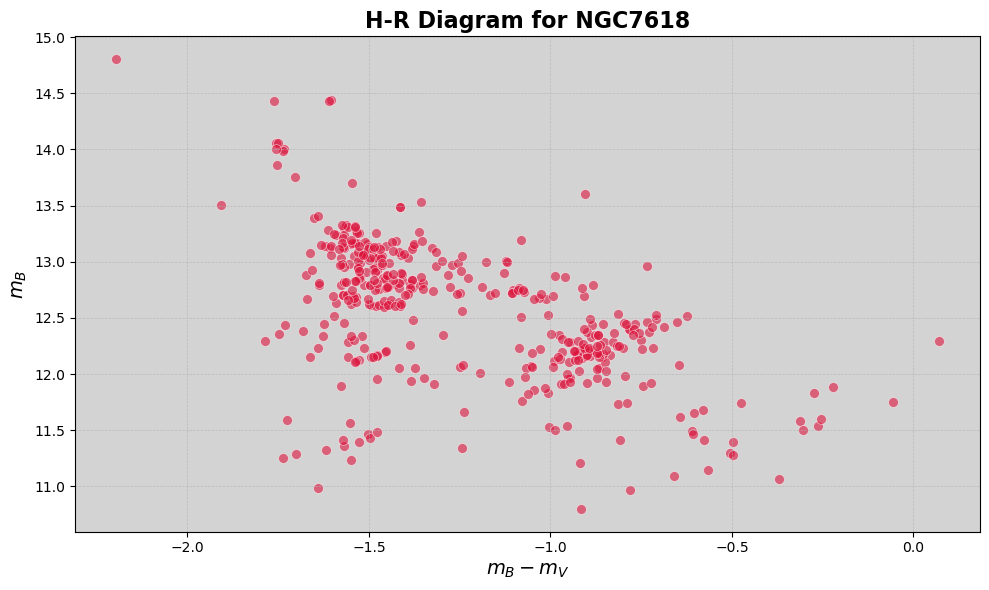

In [81]:
import matplotlib.pyplot as plt

# Data
x = df_final['m_B_x'] - df_final['m_V_y']
y = df_final['m_B_x']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with customization
ax.scatter(x, y, c='crimson', alpha=0.6, edgecolors='w', linewidth=0.5, s=50, marker="o")
ax.set_facecolor('lightgrey')

# Labels, title, and grid
ax.set_title('H-R Diagram for NGC7618', fontsize=16, fontweight='bold')
ax.set_xlabel('$m_B - m_V$', fontsize=14)
ax.set_ylabel('$m_B$', fontsize=14)
ax.grid(True, linestyle='--', which='both', linewidth=0.5, alpha=0.7)

# Tight layout
plt.tight_layout()

# Display the plot
plt.show()

#Save the plot
fig.savefig('hr_diagram.png', dpi=400)